# Comparing Ground Truth with Gridded Products

## 2. Satellite reflectance

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, datetime, timedelta
import requests
import os
import joblib

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 12}
matplotlib.rc('font', **font)

pd.plotting.register_matplotlib_converters()

In [3]:
## download Arable Mark data

import arablepy
import pandas as pd
from datetime import date

client = arablepy.ArableClient()
client.connect(email='lestes@clarku.edu', password='rollinghills88')

today = date.today()
d1 = today.strftime("%Y-%m-%d")
print("today's date ", d1) 

start = '2019-06-01'
end = '2019-09-30'


df = client.data('daily', devices= ['A000680'], start_time= start, end_time= end )
print(df)


today's date  2021-04-22
    rh_at_mint wind_speed_max wind_direction  tdew_at_mint   et  maxt  \
0          NaN           None           None           NaN  0.0  25.6   
1          NaN           None           None           NaN  0.4  21.2   
2          NaN           None           None           NaN  2.2  22.4   
3          NaN           None           None           NaN  0.2  20.7   
4          NaN           None           None           NaN  1.1  20.7   
..         ...            ...            ...           ...  ...   ...   
86        0.86           None           None           NaN  2.9  28.4   
87        0.92           None           None           NaN  0.6  20.8   
88        0.84           None           None           NaN  3.7  18.3   
89        0.86           None           None           NaN  1.0  18.9   
90        0.95           None           None          15.4  1.4  22.9   

   wind_speed_min  precip gdd_cumulative_source    cl  ...    kc  min_rh  \
0            None     

In [4]:
## download Sentinel-2 data from EE

import ee
import pandas as pd
import matplotlib.pyplot as plt
import os
#plt.style.use(['dark_background'])
ee.Initialize()

## extract lon, lat from pod data frame
pt_lon = df.long[1]
pt_lat = df.lat[1]

ee_pt = ee.Geometry.Point([pt_lon, pt_lat]);

print("server side")
print(ee_pt)
print(type(ee_pt))

print("")

## .getInfo() brings data from server-side (ee objects) to client-side (Python objects)
print("client side")
print(ee_pt.getInfo())
print(type(ee_pt.getInfo()))


server side
ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Point",
    "arguments": {
      "coordinates": {
        "constantValue": [
          -71.8065,
          42.1218
        ]
      }
    }
  }
})
<class 'ee.geometry.Geometry'>

client side
{'type': 'Point', 'coordinates': [-71.8065, 42.1218]}
<class 'dict'>


In [5]:
## create Sentinel-2 image collection

s2_pt = ee.ImageCollection("COPERNICUS/S2_SR").filterBounds(ee_pt).filterDate(start, end)

print("There are {} scenes in the collection.".format(s2_pt.size().getInfo()))

There are 90 scenes in the collection.


In [7]:
## create Earth Engine functions 

def maskS2clouds(image):
    qa = image.select('QA60')

  ## Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

  ## Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))

  ## Return the masked and scaled data, without the QA bands.
    return (image.updateMask(mask).divide(10000).select("B.*").copyProperties(image, ["system:time_start"]))


def addGCVI(image):
    gcvi = image.expression('(NIR / GREEN) - 1.0', {'NIR': image.select('B8'),'GREEN': image.select('B3')}).rename('GCVI');
    return(gcvi)    

## FILL IN CODE HERE!!!



## function for selecting singe image from image collection
def getImage(ee_ic, index):
    imageCollectionList = ee_ic.toList(ee_ic.size())
    image = imageCollectionList.get(index)
    return(ee.Image(image))



In [9]:
## FILL IN CODE HERE
## map cloud mask and addNDVI functions on to s2_pt image collection

##s2_pt_masked_ndvi = s2_pt  ## fill in code
print(s2_pt_masked_ndvi.size().getInfo())

SyntaxError: invalid syntax (<ipython-input-9-c7f12f080e21>, line 3)

In [11]:
## add functions for extracting band values from Earth Engine collection

def extractBandValue(ee_image, band_name, lon, lat):
    ee_point = ee.Geometry.Point([lon, lat])
    value = ee_image.reduceRegion(reducer = ee.Reducer.first(),
                                  geometry = ee_point,
                                  scale = 10).get(band_name).getInfo() # The scale determines the pyramid level from which to pull the input
    return(value)


def extractDate(ee_image):
    image_date_str = ee_image.getInfo()['properties']['system:index'][0:8]
    image_date = datetime(int(image_date_str[0:4]), int(image_date_str[4:6]), int(image_date_str[6:8]))
    return(image_date)


def extractTimeSeries(ee_ic, band_name, lon, lat):
    length_ic = ee_ic.size().getInfo()
    band_array = [-9999] * length_ic
    date_array = [-9999] * length_ic
    for i in range(length_ic):
        print(i)
        current_image = getImage(ee_ic, i)
        band_array[i] = extractBandValue(current_image, band_name, lon, lat)
        date_array[i] = extractDate(current_image)
    data_dict ={band_name: band_array, 'date': date_array}
    return(data_dict)




In [12]:
## FILL IN CODE HERE!!
#NDVI_ts = extractTimeSeries(...))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [13]:
print(NDVI_ts)

{'NDVI': [0.3660686181932641, 0.4057389694538723, 0.30072602216278177, 0.31413805832410485, 0.2306837131739856, 0.24357541899441343, 0.20161696042747884, 0.21730280407630562, None, None, None, None, None, None, None, 0.27066600835021093, 0.20866141732283464, 0.21989528795811522, None, None, None, None, None, None, 0.373610447867022, 0.4014598243747653, 0.33811362267189127, 0.3503609229171873, 0.4766751484308736, 0.4815436241610739, 0.5046780407264723, 0.5453551912568306, 0.5754671777671297, 0.5819811092274159, 0.6353413880856104, 0.6611399121947147, None, None, 0.7140151515151515, 0.723872137837225, 0.7680446927374301, 0.7872711421098517, 0.795585412856653, 0.8092979130907244, None, None, None, None, None, None, 0.7549738219895288, 0.7633711507293356, 0.8441305343526064, 0.8570752484619025, None, None, None, None, None, None, None, None, None, None, 0.8623393596166412, 0.8674698795180723, 0.8496932515337424, 0.8528203212551364, None, None, 0.16631130063965882, 0.17380759902991108, None

In [16]:
## convert time-series to pandas data frame
NDVI_df = pd.DataFrame(NDVI_ts)
print(NDVI_df)

        NDVI       date
0   0.366069 2019-06-02
1   0.405739 2019-06-02
2   0.300726 2019-06-04
3   0.314138 2019-06-04
4   0.230684 2019-06-07
..       ...        ...
85  0.219240 2019-09-22
86  0.217871 2019-09-25
87  0.226545 2019-09-25
88  0.188161 2019-09-27
89  0.192608 2019-09-27

[90 rows x 2 columns]


In [17]:
## filter data frame to remove NaN rows
NDVI_df_filt = NDVI_df.dropna()
print(NDVI_df_filt)

        NDVI       date
0   0.366069 2019-06-02
1   0.405739 2019-06-02
2   0.300726 2019-06-04
3   0.314138 2019-06-04
4   0.230684 2019-06-07
5   0.243575 2019-06-07
6   0.201617 2019-06-09
7   0.217303 2019-06-09
15  0.270666 2019-06-22
16  0.208661 2019-06-27
17  0.219895 2019-06-27
24  0.373610 2019-07-07
25  0.401460 2019-07-07
26  0.338114 2019-07-09
27  0.350361 2019-07-09
28  0.476675 2019-07-12
29  0.481544 2019-07-12
30  0.504678 2019-07-14
31  0.545355 2019-07-14
32  0.575467 2019-07-17
33  0.581981 2019-07-17
34  0.635341 2019-07-19
35  0.661140 2019-07-19
38  0.714015 2019-07-24
39  0.723872 2019-07-24
40  0.768045 2019-07-27
41  0.787271 2019-07-27
42  0.795585 2019-07-29
43  0.809298 2019-07-29
50  0.754974 2019-08-08
51  0.763371 2019-08-08
52  0.844131 2019-08-11
53  0.857075 2019-08-11
64  0.862339 2019-08-26
65  0.867470 2019-08-26
66  0.849693 2019-08-28
67  0.852820 2019-08-28
70  0.166311 2019-09-02
71  0.173808 2019-09-02
74  0.789010 2019-09-07
75  0.786111 201

In [25]:
NDVI_df_filt.drop_duplicates(subset=['date'],inplace=True)
print(NDVI_df_filt)

        NDVI       date
0   0.366069 2019-06-02
2   0.300726 2019-06-04
4   0.230684 2019-06-07
6   0.201617 2019-06-09
15  0.270666 2019-06-22
16  0.208661 2019-06-27
24  0.373610 2019-07-07
26  0.338114 2019-07-09
28  0.476675 2019-07-12
30  0.504678 2019-07-14
32  0.575467 2019-07-17
34  0.635341 2019-07-19
38  0.714015 2019-07-24
40  0.768045 2019-07-27
42  0.795585 2019-07-29
50  0.754974 2019-08-08
52  0.844131 2019-08-11
64  0.862339 2019-08-26
66  0.849693 2019-08-28
70  0.166311 2019-09-02
74  0.789010 2019-09-07
80  0.789970 2019-09-17
82  0.803567 2019-09-20
84  0.222499 2019-09-22
86  0.217871 2019-09-25
88  0.188161 2019-09-27


<ipython-input-25-5737deeb4aad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NDVI_df_filt.drop_duplicates(subset=['date'],inplace=True)


<AxesSubplot:xlabel='date'>

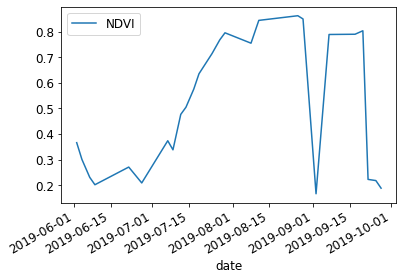

In [66]:
## plot Sentinel-2 data only
NDVI_df_filt.plot(x = 'date', y = 'NDVI')

In [27]:
### merge (join) the Sentinel-2 data frame to the pod data frame

# first we need to format the pod "time" column that we will use for the join
df['pod_datetime'] =  df['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
df.pod_datetime

0    2019-06-17
1    2019-06-18
2    2019-06-19
3    2019-06-20
4    2019-06-21
5    2019-06-22
6    2019-06-23
7    2019-06-24
8    2019-06-25
9    2019-06-26
10   2019-06-27
11   2019-06-28
12   2019-06-29
13   2019-06-30
14   2019-07-01
15   2019-07-02
16   2019-07-03
17   2019-07-04
18   2019-07-05
19   2019-07-06
20   2019-07-07
21   2019-07-08
22   2019-07-09
23   2019-07-10
24   2019-07-11
25   2019-07-12
26   2019-07-13
27   2019-07-14
28   2019-07-15
29   2019-07-16
30   2019-07-17
31   2019-07-18
32   2019-07-19
33   2019-07-20
34   2019-07-21
35   2019-07-22
36   2019-07-23
37   2019-07-24
38   2019-07-25
39   2019-07-26
40   2019-07-27
41   2019-07-28
42   2019-07-29
43   2019-07-30
44   2019-07-31
45   2019-08-01
46   2019-08-02
47   2019-08-03
48   2019-08-04
49   2019-08-05
50   2019-08-06
51   2019-08-07
52   2019-08-08
53   2019-08-09
54   2019-08-10
55   2019-08-11
56   2019-08-12
57   2019-08-13
58   2019-08-14
59   2019-08-15
60   2019-08-16
61   2019-08-17
62   201

In [29]:
### FILL IN CODE HERE

# fill in the "left_on" and "right_on" columns used for the join 
# what are we using to join the two data frames
##df2 = df.merge(NDVI_df_filt, left_on='',right_on='', how='left')


pd.set_option('display.max_rows', 1000)
print(df2)

    rh_at_mint wind_speed_max wind_direction  tdew_at_mint   et  maxt  \
0          NaN           None           None           NaN  0.0  25.6   
1          NaN           None           None           NaN  0.4  21.2   
2          NaN           None           None           NaN  2.2  22.4   
3          NaN           None           None           NaN  0.2  20.7   
4          NaN           None           None           NaN  1.1  20.7   
5          NaN           None           None           NaN  4.6  21.1   
6          NaN           None           None           NaN  5.6  24.4   
7          NaN           None           None           NaN  5.1  26.1   
8          NaN           None           None           NaN  0.4  20.6   
9          NaN           None           None           NaN  4.6  30.4   
10         NaN           None           None           NaN  5.5  27.5   
11         NaN           None           None           NaN  5.5  29.6   
12         NaN           None           None       

In [30]:
## calculate GDD (growing degree days) 
## calculate cGDD (cumulative growing degree days)

from lib.biology import *
df2['GDD'] = GDD(df2, Tlo=10., Thi=44., method='II', Tmincol='mint', Tmaxcol='maxt')
df2['cGDD'] = np.cumsum(df2['GDD'])
df2 = df2[df2['ndvi'].notna()]


/Users/michaelcecil/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Spectral Comparison'}, xlabel='date', ylabel='NDVI'>

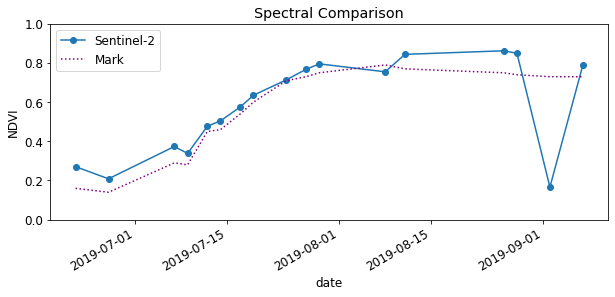

In [31]:
# create NDVI comparison plot
start, end = ( '2019-06-01', '2019-09-30')

xlim = [pd.to_datetime(start), pd.to_datetime(end)]

#fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

axes = df2.plot(x='date', y = 'NDVI', kind = 'line', figsize=(10,4), marker='o', label = 'Sentinel-2')
ylim = [0,1]

axes.set_ylim(ylim)    
axes.legend()
axes.set_ylabel('NDVI')
axes.set_title('Spectral Comparison')
df2.plot(x='date', y = 'ndvi', kind = 'line', linestyle = ':', ax = axes, color = 'purple', label = 'Mark')




/Users/michaelcecil/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'Degree Days')

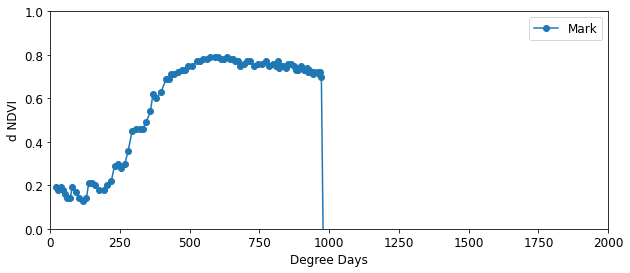

In [32]:
## create GDD vs NDVI plot

# GDD versus NDVI
axes_2 = df2.plot(x='cGDD', y = 'ndvi', kind = 'line', figsize=(10,4), marker='o', label = 'Mark')


axes_2.set_xlim([0, 2000])    
axes_2.set_ylim(ylim)    
axes_2.legend()
axes_2.set_ylabel('d NDVI')
axes_2.set_xlabel('Degree Days')

In [33]:
## save data to .csv
df2.to_csv("Mark_sentinel2_joined_2019.csv")


/Users/michaelcecil/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Problems

- Rerun the analysis for the 2020 season (June 1st to Sept 30). Download data for all three pods (A000667, A000671, A000680) and store them as separate dataframes. 
- On the NDVI comparison plot (first plot), add the data from all 3 pods to the plot as separate lines. 
- You should be able to add code like: 
### df2.plot(x='date', y = 'ndvi', kind = 'line', linestyle = ':', ax = axes, color = 'purple', label = 'Mark')




## Problems (Part 2)

- Filter out the outlier Sentinel-2 observation in early September.
- Filter out the low Mark NDVI on the last date. 
- See https://www.listendata.com/2019/07/how-to-filter-pandas-dataframe.html


## Challenge Problems
- Work through below (from Dr. Adam Wolf presentation)

4. Open the file materials/data/sensors/CSP-3_2018.csv.  What is the relationship between NDVI and AGBiomass? How about GreenLAI?  How about Height? In fact, which of these relationships has the highest correlation coefficient?

    This code may come in useful:
    ```python
obs = pd.read_csv('dat/CSP-3_2018.csv')
obs['date'] = pd.to_datetime('2018-01-01') + obs['doy'].map(timedelta)
    ```
    
    
5. Some authors have found the relationship between NDVI and fractional light absorption (fPAR) has this relationship:

    `fPAR = 1 - ((ndvi_max - NDVI)/(ndvi_max - ndvi_min))**0.625`
    
    and the relationship between fPAR and leaf area (LAI) has this relationship:

    `LAI = ln(1. - fPAR)/(-0.5)`

Are these good approximations for this dataset?
  
6. Assuming that half of downwelling shortwave (SWdw) falls as visible light (PAR), and that the light use efficiency of a crop is generally between 0 - 1 gC/MJ PAR, what is an estimate of the total absorbed light (APAR) for this crop?  How does that compare to the observed biomass?  If you wish, you can assume aboveground biomass is 80% of the total biomass.  

7. Identify when reproductive growth begins.  Create a heuristic, that is a metric derived from the NDVI curve such as its maximum or its maximumn rate of change, that corresponds to this important phenological moment.  